In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
import warnings
import operator
%matplotlib inline

In [18]:
train_df = pd.read_csv("application_train.csv")
train_df.shape

(307511, 122)

In [5]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
test_df = pd.read_csv("application_test.csv")
test_df.shape

(48744, 121)

## Missing values

To get a better understanding of our dataset, we plot a heatmap which shows where are the missing values in our data. This way we can see the holes in our dataset better.

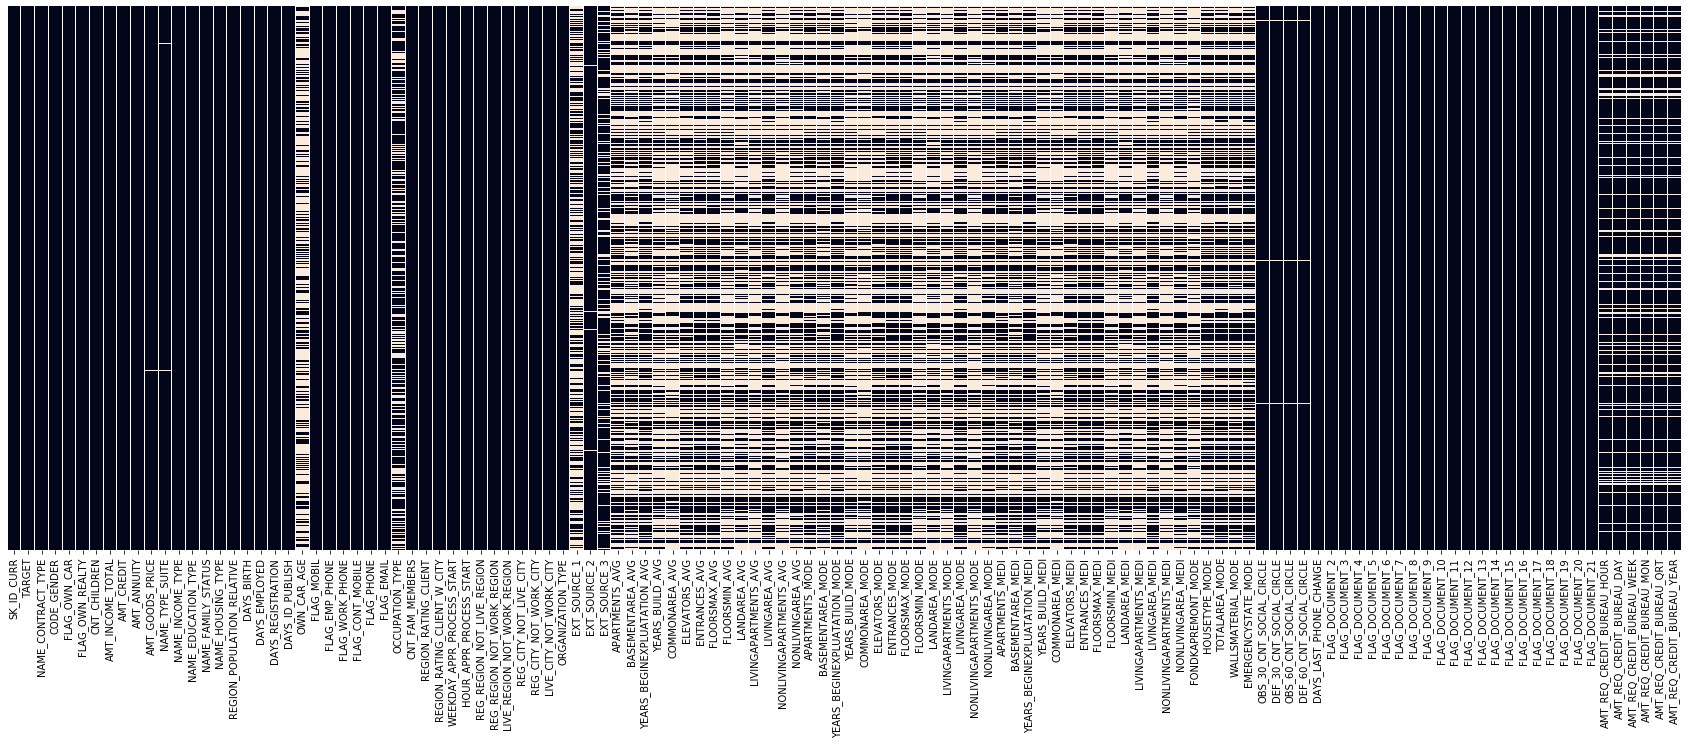

In [8]:
plt.figure(figsize=(30, 10))
sns.heatmap(train_df.isnull(), yticklabels= False , cbar = False)


In [9]:
percentage = pd.DataFrame((train_df.isnull().sum()/train_df.shape[0]).sort_values(ascending = False))
percentage.columns = ['percentage']
percentage.head(10)

,percentage
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_MODE,0.683550
LIVINGAPARTMENTS_AVG,0.683550


As we can see, in some columns there is a high percentage of missing values. we will deal with missing values later before training models.

## Label class distribution

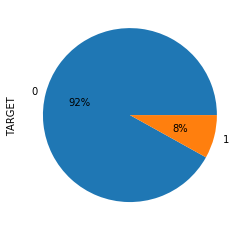

In [10]:
train_df['TARGET'].value_counts().plot(kind = 'pie' ,autopct='%1.0f%%')

As we can see the target class is unbalanced and it would be hard to train data. We will consider this fact when we want to train models with our data.

## Types of columns

In [11]:
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

So we have 16 catogerical columns and we need to encode them. Let's see in detail how many categories each column have.

In [12]:
for col in train_df.select_dtypes(include=['object']) :
    print('column %s has %s unique categories' % (col,len(train_df[col].unique())))

column NAME_CONTRACT_TYPE has 2 unique categories
column CODE_GENDER has 3 unique categories
column FLAG_OWN_CAR has 2 unique categories
column FLAG_OWN_REALTY has 2 unique categories
column NAME_TYPE_SUITE has 8 unique categories
column NAME_INCOME_TYPE has 8 unique categories
column NAME_EDUCATION_TYPE has 5 unique categories
column NAME_FAMILY_STATUS has 6 unique categories
column NAME_HOUSING_TYPE has 6 unique categories
column OCCUPATION_TYPE has 19 unique categories
column WEEKDAY_APPR_PROCESS_START has 7 unique categories
column ORGANIZATION_TYPE has 58 unique categories
column FONDKAPREMONT_MODE has 5 unique categories
column HOUSETYPE_MODE has 4 unique categories
column WALLSMATERIAL_MODE has 8 unique categories
column EMERGENCYSTATE_MODE has 3 unique categories


We have 16 categorical columns, in each of which from 2 to 58 different options of values. We use one-hot-encoding to transform them to numerical values.

### One-hot-encoding

In [9]:
# Write a function for one hot encoding to handle categorical features
def one_hot_encoding(df) :
    for col in list(df.columns) :
        if df[col].dtype == 'object' :
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
            df = df.drop(columns = col)  #remove the categorical column after hot encoding
    return(df)

In [20]:
train_df = one_hot_encoding(train_df)
test_df = one_hot_encoding(test_df)

In [17]:
print('size of train_df after one-hot-encoding is: ', train_df.shape)
print('size of test_df after one-hot-encoding is: ', test_df.shape)

size of train_df after one-hot-encoding is:  (307511, 246)
size of test_df after one-hot-encoding is:  (48744, 242)


As we can see we have 3 more columns(rather than target) in train dataframe compared to test dataframe. So we should make an alignment between them.



### Alignment

In [21]:
target_label = train_df['TARGET'] #saving target column to add it afterwards since it will disappear after alignment
train_df, test_df = train_df.align(test_df, join = 'inner', axis = 1)
train_df['TARGET'] = target_label #add target column to train_df

In [19]:
print('size of train_df after alignment is: ', train_df.shape)
print('size of test_df after alignment is: ', test_df.shape)

size of train_df after alignment is:  (307511, 243)
size of test_df after alignment is:  (48744, 242)


Now the the train and test data frame are aligned

## Data correlation

In this step we calculate pearson correlation coefficient between each column and the target column, so we will have a basic understanding that which columns are more related to the target.

In [20]:
corr = train_df.corr()['TARGET'].sort_values()
print(corr.tail(15)) #to get most positively correlated features
print(corr.head(15)) #to get most negatively correlated features

DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64
EXT_SOURCE_3                           -0

As we can see Age, External soureces, gender, education, income type and region are more related to the target(although non of them has very high correlation) Let's do some more analysis on these factors to get a better knowledge of our data

### Age

Text(0, 0.5, 'Count')

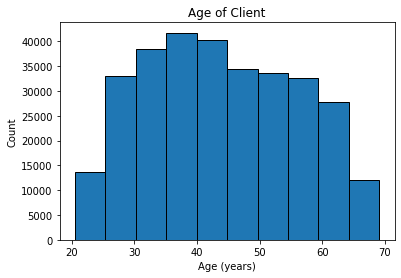

In [21]:
plt.hist(-train_df['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 10)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

As we can see most of clients are between 30 and 45. let's see how does age change customers behavior for paying loans.

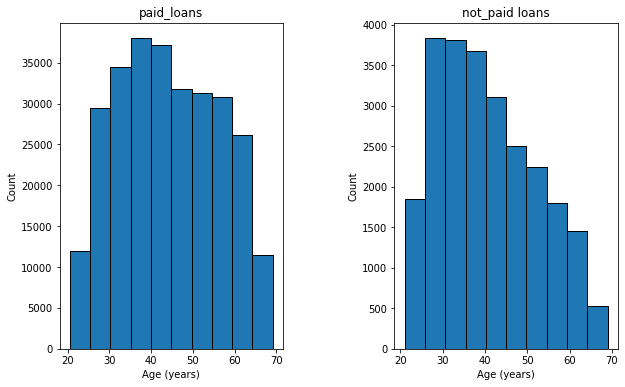

In [22]:
Age = train_df[['DAYS_BIRTH','TARGET']].copy(deep=True)
warnings.filterwarnings('ignore')
imputer = SimpleImputer(strategy = "median")
imputer.fit(Age)
Age.loc[:] = imputer.transform(Age)

#change Age from days to years
Age.loc[Age['TARGET']==0 ,'paid'] = -Age.loc[Age['TARGET']==0,'DAYS_BIRTH']/365
Age.loc[Age['TARGET']==1 ,'not_paid'] = -Age.loc[Age['TARGET']==1,'DAYS_BIRTH']/365


fig = plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(Age['paid'],edgecolor = 'k', bins = 10)
plt.title('paid_loans')
plt.xlabel('Age (years)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(Age['not_paid'],edgecolor = 'k', bins = 10)
plt.title('not_paid loans')
plt.xlabel('Age (years)')
plt.ylabel('Count')

plt.subplots_adjust(wspace = .5)

plt.show()


As we can see in not_paid loans subplot, as the age of customers increases, the possibility that they will pay the loan back increase.

### Education level 

<Figure size 720x720 with 0 Axes>

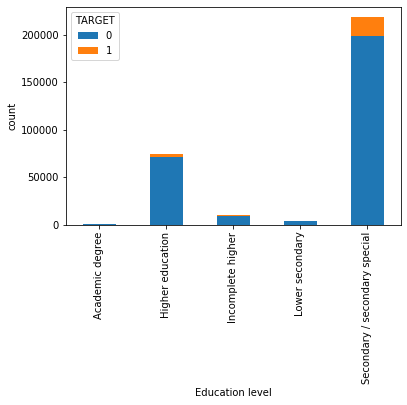

In [24]:
train_df2 = pd.read_csv("application_train.csv")
edu = train_df2[['NAME_EDUCATION_TYPE','TARGET']].copy(deep=True)
edu = edu.dropna(how='any',axis=0)
fig = plt.figure(figsize=(10, 10))
edu.groupby(['NAME_EDUCATION_TYPE','TARGET']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('Education level')
plt.ylabel('count')
plt.show()

### Gender

<Figure size 720x720 with 0 Axes>

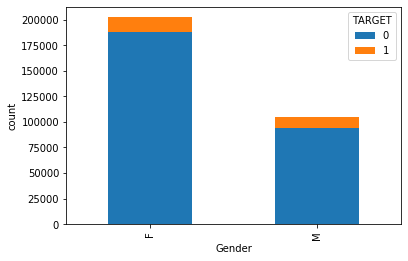

In [25]:
gender = train_df2[['CODE_GENDER','TARGET']].copy(deep=True)
gender = gender.replace('XNA', np.nan)
gender = gender.dropna(how='any',axis=0)
fig = plt.figure(figsize=(10, 10))
gender.groupby(['CODE_GENDER','TARGET']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()

Women clients are almost twice as many men, while men show higher risk.

### Family Status

<Figure size 720x720 with 0 Axes>

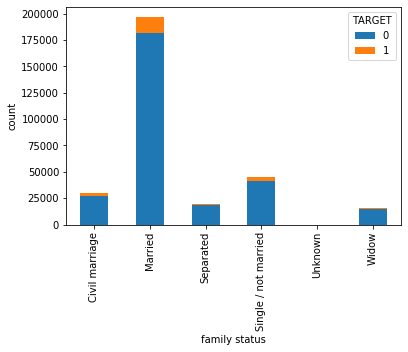

In [27]:
FStatus = train_df2[['NAME_FAMILY_STATUS','TARGET']].copy(deep=True)
FStatus = FStatus.dropna(how='any',axis=0)
fig = plt.figure(figsize=(10, 10))
FStatus.groupby(['NAME_FAMILY_STATUS','TARGET']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('family status')
plt.ylabel('count')
plt.show()

While the majority of clients are married, customers in unmarried and single relationships are less risky.

## Feature engineering

### Adding some useful features

In [22]:
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # Deleting outsiders
train_df['CREDIT_DIV_ANNUITY'] = train_df['AMT_CREDIT']/train_df['AMT_ANNUITY']
train_df['ANNUITY_INCOME_PERCENT'] = train_df['AMT_ANNUITY'] / train_df['AMT_INCOME_TOTAL']
train_df['BIRTH_DIV_EMPLOYED'] = train_df['DAYS_BIRTH']/train_df['DAYS_EMPLOYED']
train_df['DAYREG_DIV_DAYPUB'] = train_df['DAYS_REGISTRATION']/train_df['DAYS_ID_PUBLISH']
train_df['CREDIT_MINUS_GOOD'] = train_df['AMT_CREDIT']/train_df['AMT_GOODS_PRICE']
train_df['INCOME_CHILD'] = train_df['AMT_INCOME_TOTAL']/train_df['CNT_CHILDREN']
train_df['INCOME_DIV_FAM'] = train_df['AMT_INCOME_TOTAL']/train_df['CNT_FAM_MEMBERS']



In [54]:
test_df['CREDIT_DIV_ANNUITY'] = test_df['AMT_CREDIT']/test_df['AMT_ANNUITY']
test_df['ANNUITY_INCOME_PERCENT'] = test_df['AMT_ANNUITY'] / test_df['AMT_INCOME_TOTAL']
test_df['BIRTH_DIV_EMPLOYED'] = test_df['DAYS_BIRTH']/test_df['DAYS_EMPLOYED']
test_df['DAYREG_DIV_DAYPUB'] = test_df['DAYS_REGISTRATION']/test_df['DAYS_ID_PUBLISH']
test_df['CREDIT_MINUS_GOOD'] = test_df['AMT_CREDIT']/test_df['AMT_GOODS_PRICE']
test_df['INCOME_CHILD'] = test_df['AMT_INCOME_TOTAL']/test_df['CNT_CHILDREN']
test_df['INCOME_DIV_FAM'] = test_df['AMT_INCOME_TOTAL']/test_df['CNT_FAM_MEMBERS']


### Adding polynomial features

In this step we try to create new features from available important ones. One way to do that is to use polynomial method and create features that are the degree of the features available. Since creating polynomial features may not always improve our model, we create another data frame with theses features and try to learn data with and without them.

We choose 5 important features(based on their correlation with target) : EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH, CODE_GENDER_F and use PolynomialFeatures class from Scikit-Learn with degree 3.

In [31]:
important_features = train_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','CODE_GENDER_F' ]]
important_features_test = test_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','CODE_GENDER_F' ]]
imputer = SimpleImputer(strategy = 'median') #replacing null values with the median of that column
important_features =  imputer.fit_transform(important_features)
important_features_test = imputer.fit_transform(important_features_test)
polynom = PolynomialFeatures(degree = 3)
poly_features = polynom.fit_transform(important_features) #applying PolynomialFeatures to train set
poly_features_test = polynom.fit_transform(important_features_test ) #applying PolynomialFeatures to test set
print(poly_features.shape)

(307511, 56)


Now we havve 56 polynomial features from 5 original important features. Now we calculate correlation between these polynomial features and the target to see how these features are related to the label.

In [32]:
# We create a data frame from all polynomial features that we created in previous step and then calculate correlations
poly_features = pd.DataFrame(poly_features , columns = polynom.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                    'EXT_SOURCE_3', 'DAYS_BIRTH', 'CODE_GENDER_F']))

poly_features_test = pd.DataFrame(poly_features_test , columns = polynom.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                    'EXT_SOURCE_3', 'DAYS_BIRTH', 'CODE_GENDER_F']))

poly_features.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,CODE_GENDER_F,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,...,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 CODE_GENDER_F,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH CODE_GENDER_F,EXT_SOURCE_3 CODE_GENDER_F^2,DAYS_BIRTH^3,DAYS_BIRTH^2 CODE_GENDER_F,DAYS_BIRTH CODE_GENDER_F^2,CODE_GENDER_F^3
0,1.0,0.083037,0.262949,0.139376,-9461.0,0.0,0.006895,0.021834,0.011573,-785.612748,...,0.002707,-183.785678,0.000000,1.247560e+07,-0.000000,0.000000,-8.468590e+11,0.0,-0.0,0.0
1,1.0,0.311267,0.622246,0.535276,-16765.0,1.0,0.096887,0.193685,0.166614,-5218.396475,...,0.153368,-4803.518937,0.286521,1.504475e+08,-8973.906339,0.535276,-4.712058e+12,281065225.0,-16765.0,1.0
2,1.0,0.505998,0.555912,0.729567,-19046.0,0.0,0.256034,0.281290,0.369159,-9637.236584,...,0.388325,-10137.567875,0.000000,2.646504e+08,-0.000000,0.000000,-6.908939e+12,0.0,-0.0,0.0
3,1.0,0.505998,0.650442,0.535276,-19005.0,1.0,0.256034,0.329122,0.270849,-9616.490669,...,0.153368,-5445.325225,0.286521,1.933364e+08,-10172.925140,0.535276,-6.864416e+12,361190025.0,-19005.0,1.0
4,1.0,0.505998,0.322738,0.535276,-19932.0,0.0,0.256034,0.163305,0.270849,-10085.550751,...,0.153368,-5710.929881,0.000000,2.126570e+08,-0.000000,0.000000,-7.918677e+12,0.0,-0.0,0.0


In [33]:
poly_features = poly_features.drop('1' , axis = 1) # The first featur with degree 0 is useless so we drop it
poly_features_test = poly_features_test.drop('1' , axis = 1)
poly_features ['TARGET'] = train_df['TARGET']
corr = poly_features.corr()['TARGET'].sort_values()
print(corr.tail(15)) #to get most positively correlated features
print(corr.head(15)) #to get most negatively correlated features

DAYS_BIRTH CODE_GENDER_F^2               0.075350
DAYS_BIRTH                               0.078239
EXT_SOURCE_1 DAYS_BIRTH CODE_GENDER_F    0.091402
EXT_SOURCE_1^2 DAYS_BIRTH                0.097507
EXT_SOURCE_1 DAYS_BIRTH                  0.104882
EXT_SOURCE_2 DAYS_BIRTH CODE_GENDER_F    0.113053
EXT_SOURCE_3 DAYS_BIRTH CODE_GENDER_F    0.114184
EXT_SOURCE_3^2 DAYS_BIRTH                0.141777
EXT_SOURCE_2^2 DAYS_BIRTH                0.149313
EXT_SOURCE_3 DAYS_BIRTH                  0.150109
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH     0.151816
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     0.155891
EXT_SOURCE_2 DAYS_BIRTH                  0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     0.181283
TARGET                                   1.000000
Name: TARGET, dtype: float64
EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_

In [34]:
poly_features.shape

(307511, 56)

As we can see now, some of these polynomial features have more correlation with the target class.

Now we create new train and test data sets and add these polynomial features. Later for training model we also use these datasets with polynomial features to see if it would improve our model.

In [35]:
poly_features['SK_ID_CURR'] = train_df['SK_ID_CURR']  #adding Id column so we can merge these datasets later
poly_features = poly_features.drop('TARGET', axis = 1)
poly_features_test['SK_ID_CURR'] = test_df['SK_ID_CURR']
poly_train = train_df.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
poly_test = test_df.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')
poly_train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH_x,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 CODE_GENDER_F,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH CODE_GENDER_F,EXT_SOURCE_3 CODE_GENDER_F^2,DAYS_BIRTH^3,DAYS_BIRTH^2 CODE_GENDER_F,DAYS_BIRTH CODE_GENDER_F^2,CODE_GENDER_F^3
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,...,0.002707,-183.785678,0.000000,1.247560e+07,-0.000000,0.000000,-8.468590e+11,0.0,-0.0,0.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,...,0.153368,-4803.518937,0.286521,1.504475e+08,-8973.906339,0.535276,-4.712058e+12,281065225.0,-16765.0,1.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,...,0.388325,-10137.567875,0.000000,2.646504e+08,-0.000000,0.000000,-6.908939e+12,0.0,-0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,...,0.153368,-5445.325225,0.286521,1.933364e+08,-10172.925140,0.535276,-6.864416e+12,361190025.0,-19005.0,1.0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,...,0.153368,-5710.929881,0.000000,2.126570e+08,-0.000000,0.000000,-7.918677e+12,0.0,-0.0,0.0


## Adding data from other tables

### <font color='blue'>bureau_balance table</font>

In [25]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [38]:
bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

Meaning of differnet values of STATUS column is as following :

C - closed, that is, repaid credit. X - unknown status. 0 - current loan, no delinquency. 1 - 1-30 days overdue, 2 - 31-60 days overdue, and so on up to status 5 - the loan is sold to a third party or written off

We can use this STATUS column and define a risk factor by allocating a value to each status and then calculate sum of them for each SK_ID_BUREAU

In [26]:
bureau_balance['STATUS'] = bureau_balance['STATUS'].map({'C' : 0 , '0' : 0 , 'X' : .1 , '1' : 1 , 
                                                      '2' : 2 , '3' : 3 , '4' :4 , '5' : 5})
# Allocate .1 for X because in this case the status is unknown and it's not reasonable to map a high risk to it

bureau_balance_final = bureau_balance.groupby('SK_ID_BUREAU', as_index=False)['STATUS'].sum()
bureau_balance_final = bureau_balance_final.rename(columns = {'STATUS' : 'BB_RISK'})
bureau_balance_final.head()

,SK_ID_BUREAU,BB_RISK
0,5001709,1.1
1,5001710,3.0
2,5001711,0.1
3,5001712,0.0
4,5001713,2.2


### <font color='blue'>bureau table</font>

In this step, we first add the risk value that we calculated in previous step to the bureau table and fill null values with 0

In [27]:
bureau = pd.read_csv("bureau.csv")
bureau= bureau.merge(bureau_balance_final, on = 'SK_ID_BUREAU', how = 'left')
bureau['BB_RISK'] = bureau['BB_RISK'].fillna(0) 
bureau = one_hot_encoding(bureau)
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,0,0,0,0,0,0,0,0,0,0


Now we get the mean of bureau table features for each SK_ID_CURR and also number of previous loans that each customer got before

In [28]:
bureau_mean = bureau.groupby('SK_ID_CURR').mean()
previous_loans = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count() #number of previous loans for each customer
previous_loans = previous_loans.rename(columns = {"SK_ID_CURR" : "SK_ID_CURR", "SK_ID_BUREAU" : "PLoan_num"})
bureau_mean= bureau_mean.merge(previous_loans, on = 'SK_ID_CURR', how = 'left')
bureau_mean = bureau_mean.drop(columns = "SK_ID_BUREAU" )
bureau_mean.head()

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,PLoan_num
0,100001,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,100003,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,100005,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


Now we define a new variable from exisiting varaibles that may be useful and it is how often the cusomer took loans in past, was it on a regular basis or for a short period? Each can have different interpretation.

In [29]:
frequency = bureau[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']].groupby(by=['SK_ID_CURR'])
frequency1 =  frequency.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending=False)).reset_index(drop=True)
frequency1['Loan_FRQ'] = frequency1.groupby(by=['SK_ID_CURR'])['DAYS_CREDIT'].diff()

Now need to find mean of Loan_FRQ for each SK_ID_CURR. First, I drop null values(beacause when we calculate diff, the diff value for the first bureau of each SK_ID_CURR is NAN ) and then calculate mean values for each SK_ID_CURR

In [30]:
frequency1 = frequency1.dropna(subset = ['Loan_FRQ'])
frequency1 = frequency1.groupby('SK_ID_CURR', as_index=False)['Loan_FRQ'].mean()




# Now we should merge frequency1 and bureau_mean database
bureau_mean= bureau_mean.merge(frequency1, on = 'SK_ID_CURR', how = 'left')

#we have null values in Loan_FRQ column if there was just 1 previous loan
#fill null values of this column with the value  of DAYS_CREDIT column
bureau_mean["Loan_FRQ"] = np.where(bureau_mean["Loan_FRQ"].isnull(), bureau_mean['DAYS_CREDIT'], bureau_mean["Loan_FRQ"])

bureau_mean["Loan_FRQ"] = bureau_mean["Loan_FRQ"].abs()


bureau_mean.head(10)

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,PLoan_num,Loan_FRQ
0,100001,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,253.833333
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,190.571429
2,100003,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,660.000000
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,918.000000
4,100005,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,155.500000
5,100007,-1149.000000,0.0,-783.000000,-783.000000,0.000,0.0,146250.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1149.000000
6,100008,-757.333333,0.0,-391.333333,-909.000000,0.000,0.0,156148.500000,80019.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,509.500000
7,100009,-1271.500000,0.0,-794.937500,-1108.500000,0.000,0.0,266711.750000,76953.535714,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,155.470588
8,100010,-1939.500000,0.0,-119.500000,-1138.000000,NaN,0.0,495000.000000,174003.750000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1603.000000
9,100011,-1773.000000,0.0,-1293.250000,-1463.250000,5073.615,0.0,108807.075000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,399.666667


In [31]:
# Now we fill null values with the value of median
imputer = SimpleImputer(strategy = "median")
imputer.fit(bureau_mean)
bureau_mean.loc[:] = imputer.transform(bureau_mean)

bureau_mean.columns = ['BUR_' + col for col in bureau_mean.columns]
bureau_mean = bureau_mean.rename(columns = {'BUR_SK_ID_CURR' : 'SK_ID_CURR'})



### <font color='blue'>POS_CASH_balance table</font>

In [32]:
pos_cash = pd.read_csv("POS_CASH_balance.csv")
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [33]:
pos_cash = one_hot_encoding(pos_cash)

pos_count = pos_cash[[ 'SK_ID_PREV', 'SK_ID_CURR']].groupby(by = 'SK_ID_CURR').count()
pos_count = pos_count.rename(columns= {'SK_ID_CURR' : 'SK_ID_CURR', 'SK_ID_PREV' : 'prev_pos_count'})
pos_avg = pos_cash.groupby('SK_ID_CURR').mean()
pos_avg = pos_avg.merge(pos_count,  how='left', on='SK_ID_CURR')
pos_avg = pos_avg.drop('SK_ID_PREV', axis = 1)
pos_avg.head()

,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_XNA,prev_pos_count
SK_ID_CURR,,,,,,,,,,,,,,,
100001,-72.555556,4.000000,1.444444,0.777778,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,9
100002,-10.000000,24.000000,15.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,19
100003,-43.785714,10.107143,5.785714,0.000000,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,28
100004,-25.500000,3.750000,2.250000,0.000000,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,4
100005,-20.000000,11.700000,7.200000,0.000000,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,11


In [34]:
# changing column names to avoid any problem when we want to merge these tables with train and test
pos_avg.columns = ['POS_' + col for col in pos_avg.columns]
pos_avg = pos_avg.rename(columns = {'POS_SK_ID_CURR' : 'SK_ID_CURR'})

### <font color='blue'>installments_payments table</font>

In [35]:
ins_pay = pd.read_csv("installments_payments.csv")
ins_pay = one_hot_encoding(ins_pay)
ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [36]:
ins_count = ins_pay[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
ins_count = ins_count.rename(columns = {'SK_ID_CURR' : 'SK_ID_CURR' , 'SK_ID_PREV' : 'ins_count'})
ins_avg = ins_pay.groupby('SK_ID_CURR').mean()
ins_avg  = ins_avg.merge(ins_count,  how='left', on='SK_ID_CURR')
ins_avg = ins_avg.drop('SK_ID_PREV', axis = 1)
ins_avg.head()

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,ins_count
SK_ID_CURR,,,,,,,
100001,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143,7
100002,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,19
100003,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,25
100004,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3
100005,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000,9


####  Adding new features

In [37]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins_avg['PAYMENT_PERC'] = ins_avg['AMT_PAYMENT'] / ins_avg['AMT_INSTALMENT']
ins_avg['PAYMENT_DIFF'] = ins_avg['AMT_INSTALMENT'] - ins_avg['AMT_PAYMENT']

# Days past due and days before due (no negative values)
ins_avg['DPD'] = ins_avg['DAYS_ENTRY_PAYMENT'] - ins_avg['DAYS_INSTALMENT']
ins_avg['DBD'] = ins_avg['DAYS_INSTALMENT'] - ins_avg['DAYS_ENTRY_PAYMENT']
ins_avg['DPD'] = ins_avg['DPD'].apply(lambda x: x if x > 0 else 0)
ins_avg['DBD'] = ins_avg['DBD'].apply(lambda x: x if x > 0 else 0)
ins_avg.head()

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,ins_count,PAYMENT_PERC,PAYMENT_DIFF,DPD,DBD
SK_ID_CURR,,,,,,,,,,,
100001,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143,7,1.0,0.0,0.0,7.285714
100002,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,19,1.0,0.0,0.0,20.421053
100003,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,25,1.0,0.0,0.0,7.160000
100004,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3,1.0,0.0,0.0,7.666667
100005,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000,9,1.0,0.0,0.0,23.555556


In [51]:
#analyze null values 
ins_avg.isnull().sum()

NUM_INSTALMENT_VERSION    0
NUM_INSTALMENT_NUMBER     0
DAYS_INSTALMENT           0
DAYS_ENTRY_PAYMENT        9
AMT_INSTALMENT            0
AMT_PAYMENT               9
ins_count                 0
PAYMENT_PERC              9
PAYMENT_DIFF              9
DPD                       0
DBD                       0
dtype: int64

There are just 9 rows with null values in DAYS_ENTRY_PAYMENT and AMT_PAYMENT columns (also in new columns that we created from them). We fill these null values with the mean of the column

In [38]:
ins_avg = ins_avg.fillna(ins_avg.mean())
ins_avg.head()

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,ins_count,PAYMENT_PERC,PAYMENT_DIFF,DPD,DBD
SK_ID_CURR,,,,,,,,,,,
100001,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143,7,1.0,0.0,0.0,7.285714
100002,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,19,1.0,0.0,0.0,20.421053
100003,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,25,1.0,0.0,0.0,7.160000
100004,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3,1.0,0.0,0.0,7.666667
100005,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000,9,1.0,0.0,0.0,23.555556


In [39]:
#changing columns name
ins_avg.columns = ['ins_' + col for col in ins_avg.columns]
ins_avg = ins_avg.rename(columns = {'ins_SK_ID_CURR' : 'SK_ID_CURR'})


### <font color='blue'>credit_card_balance table</font> 

In [6]:
cc = pd.read_csv('credit_card_balance.csv')
cc.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [11]:
# handling categorical features
cc = one_hot_encoding(cc)


# filling null values with median
imputer = SimpleImputer(strategy = "median")
imputer.fit(cc)
cc.loc[:] = imputer.transform(cc)

# Adding number of credit cards
cc_count = cc[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_count = cc_count.rename(columns = {'SK_ID_CURR' : 'SK_ID_CURR' , 'SK_ID_PREV' : 'cc_count'})

# calculating the mean of each feature for each customer
cc_avg = cc.groupby('SK_ID_CURR').mean()
cc_avg  = cc_avg.merge(cc_count,  how='left', on='SK_ID_CURR')
cc_avg = cc_avg.drop('SK_ID_PREV', axis = 1)
cc_avg.head()

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,...,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed,cc_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006.0,-3.5,0.000000,270000.000000,5961.324822,0.000000,288.169582,2968.804848,0.000000,10280.537702,0.000000,...,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,6
100011.0,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.000000,0.000000,3950.599988,4843.064189,4520.067568,...,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,74
100013.0,-48.5,18159.919219,131718.750000,6325.707801,5953.125000,18.010599,185.550303,1606.619259,7168.346250,6817.172344,...,0.010417,0.010417,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,96
100021.0,-10.0,0.000000,675000.000000,5961.324822,0.000000,288.169582,2968.804848,0.000000,10280.537702,0.000000,...,0.000000,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0,17
100023.0,-7.5,0.000000,135000.000000,5961.324822,0.000000,288.169582,2968.804848,0.000000,10280.537702,0.000000,...,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,8


In [12]:
#changing columns name
cc_avg.columns = ['ins_' + col for col in cc_avg.columns]
cc_avg = cc_avg.rename(columns = {'ins_SK_ID_CURR' : 'SK_ID_CURR'})

### <font color='blue'>previous_application table</font>


In [13]:
pre_app = pd.read_csv('previous_application.csv')
pre_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# handling categorical features
pre_app = one_hot_encoding(pre_app)


# Adding number of credit cards
pre_count = pre_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pre_count = pre_count.rename(columns = {'SK_ID_CURR' : 'SK_ID_CURR' , 'SK_ID_PREV' : 'pre_app_count'})

# calculating the mean of each feature for each customer
app_avg = pre_app.groupby('SK_ID_CURR').mean()
app_avg  = app_avg.merge(pre_count,  how='left', on='SK_ID_CURR')
app_avg = app_avg.drop('SK_ID_PREV', axis = 1)
app_avg.head()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,pre_app_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,NaN,NaN,...,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1
100002,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,NaN,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,1
100003,56553.990,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050030,NaN,NaN,...,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,3
100004,5357.250,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212008,NaN,NaN,...,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,1
100005,4813.200,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108964,NaN,NaN,...,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,2


In [15]:
# filling null values with median
imputer = SimpleImputer(strategy = "median")
imputer.fit(app_avg)
app_avg.loc[:] = imputer.transform(app_avg)

In [16]:
#changing columns name
app_avg.columns = ['app_' + col for col in app_avg.columns]
app_avg = app_avg.rename(columns = {'app_SK_ID_CURR' : 'SK_ID_CURR'})

### Merging tables with train and test set 

In this step we merge the datasets that we created in last step with trian and test dataset. Since not all applicants have previous applications or loans, we fill null values of columns of these new datasets with 0 .

In [23]:
def merge_dataset(df1,df2,key):
    df2_cols = list(df2.columns)
    df1 = df1.merge(df2, how='left', on= key)
    df1[df2_cols] = df1[df2_cols].fillna(0)
    return df1

In [40]:
# Adding Bureau table
train_df = merge_dataset(train_df, bureau_mean,  'SK_ID_CURR')
test_df = merge_dataset(test_df, bureau_mean,  'SK_ID_CURR' )

In [41]:
# Adding POS_CASH_balance table
train_df = merge_dataset(train_df, pos_avg ,  'SK_ID_CURR')
test_df = merge_dataset(test_df, pos_avg ,  'SK_ID_CURR' )

In [42]:
# Adding installments_payments table
train_df = merge_dataset(train_df, ins_avg ,  'SK_ID_CURR')
test_df = merge_dataset(test_df, ins_avg ,  'SK_ID_CURR' )


In [43]:
# Adding credit_card_balance table
train_df = merge_dataset(train_df, cc_avg ,  'SK_ID_CURR')
test_df = merge_dataset(test_df, cc_avg ,  'SK_ID_CURR' )

In [45]:
# Adding previous_application table
train_df = merge_dataset(train_df, app_avg ,  'SK_ID_CURR')
test_df = merge_dataset(test_df, app_avg ,  'SK_ID_CURR' )

In [46]:
# Adding some new useful features
train_df['INTEREST'] = train_df['app_CNT_PAYMENT']*train_df['AMT_ANNUITY'] - train_df['AMT_CREDIT']
train_df['INTEREST_RATE'] = 2*12*train_df['INTEREST']/(train_df['AMT_CREDIT']*(train_df['app_CNT_PAYMENT']+1))
train_df['INTEREST_SHARE'] = train_df['INTEREST']/train_df['AMT_CREDIT']

In [56]:
test_df['INTEREST'] = test_df['app_CNT_PAYMENT']*test_df['AMT_ANNUITY'] - test_df['AMT_CREDIT']
test_df['INTEREST_RATE'] = 2*12*test_df['INTEREST']/(test_df['AMT_CREDIT']*(test_df['app_CNT_PAYMENT']+1))
test_df['INTEREST_SHARE'] = test_df['INTEREST']/test_df['AMT_CREDIT']

In [47]:
train_df.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,app_PRODUCT_COMBINATION_POS industry with interest,app_PRODUCT_COMBINATION_POS industry without interest,app_PRODUCT_COMBINATION_POS mobile with interest,app_PRODUCT_COMBINATION_POS mobile without interest,app_PRODUCT_COMBINATION_POS other with interest,app_PRODUCT_COMBINATION_POS others without interest,app_pre_app_count,INTEREST,INTEREST_RATE,INTEREST_SHARE
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,...,0.000000,0.0,0.000000,0.0,1.0,0.0,1.0,186214.5,0.439663,0.457982
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,...,0.333333,0.0,0.000000,0.0,0.0,0.0,3.0,-936517.5,-1.579673,-0.724017
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,...,0.000000,0.0,0.000000,1.0,0.0,0.0,1.0,-108000.0,-3.840000,-0.800000
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,...,0.111111,0.0,0.000000,0.0,0.0,0.0,9.0,370107.0,1.183651,1.183651
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,...,0.000000,0.0,0.166667,0.0,0.0,0.0,6.0,-61113.0,-0.131958,-0.119129


In [48]:
train_df.to_csv('processed.csv', encoding='utf-8', index=False)


In [57]:
test_df.to_csv('processed_test.csv' , encoding='utf-8', index=False)

# Modeling

In [49]:
 train_df = pd.read_csv('processed.csv')

In [58]:
test_df =  pd.read_csv('processed_test.csv')

In [59]:
test_df.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CREDIT_DIV_ANNUITY,ANNUITY_INCOME_PERCENT,BIRTH_DIV_EMPLOYED,DAYREG_DIV_DAYPUB,CREDIT_MINUS_GOOD,INCOME_CHILD,INCOME_DIV_FAM,INTEREST,INTEREST_RATE,INTEREST_SHARE
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,27.664697,0.152300,8.261486,6.366995,1.2640,inf,67500.0,-404316.0,-1.895527,-0.710823
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,12.824870,0.175455,4.042068,5.617991,1.2376,inf,49500.0,-14328.0,-0.118741,-0.064318
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,9.505482,0.344578,4.494841,0.620896,1.0528,inf,101250.0,546204.0,1.078048,0.823509
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,32.130726,0.155614,7.489818,0.475285,1.0000,157500.0,78750.0,-1019457.0,-1.259561,-0.647274
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,19.506034,0.178150,5.951620,0.938527,1.0000,180000.0,60000.0,144108.0,0.221173,0.230388


#### Checking for Nan, inf or -inf values and substituding them with the mean of each numeric columns


In [18]:
# Substituting inf and -inf values with nan
train_df = train_df.replace([np.inf, -np.inf], np.nan)

In [19]:
# Filling the Nan values in the new numeric columns with the mean
for column in list(train_df.columns):
    if train_df[column].dtypes == 'float64':
        train_df[column] = train_df[column].fillna(train_df[column].mean())

In [20]:
# Checking if there are still any problems into the dataframe
train_df.isnull().any().any()

False

---

In [21]:
# Selecting the 'SK_ID_CURR' column for future use
client_names = train_df[['SK_ID_CURR']]
client_names

,SK_ID_CURR
0,100002
1,100003
2,100004
3,100006
4,100007
...,...
307506,456251
307507,456252
307508,456253
307509,456254


In [22]:
# Splitting dataframe in features and target variable
feature_cols = list(train_df.columns)
y = train_df.TARGET.values # Target variable
train_df = train_df[feature_cols].drop(['TARGET'], axis = 1) 
train_df = train_df.drop(['SK_ID_CURR'], axis = 1) # Features


#### Dividing the data into train, val and test datasets

Now that we have defined the initial dataframe of features and the Target variable array, we can divide our dataset into training, validation and testing sets, and then select suitable methods for binary classification in order to develop our statistical model.

In [23]:
# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(train_df, y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)

print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (215257, 506)
Shape of X_val: (46127, 506)
Shape of X_test: (46127, 506)


As we can see, we can count over 500 columns in our dataframes, and so many different features can consistently slow our models and generate too much noise, so that becomes even more difficult finding the correct probability that each client will or won't pay back the loan.

For these reasons, we already decided to select the best feature with light gbm

In [24]:
model_sel = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
model_sel.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.756421	valid_0's binary_logloss: 0.590982
[400]	valid_0's auc: 0.770388	valid_0's binary_logloss: 0.563871
[600]	valid_0's auc: 0.776057	valid_0's binary_logloss: 0.549486
[800]	valid_0's auc: 0.778801	valid_0's binary_logloss: 0.539544
[1000]	valid_0's auc: 0.780082	valid_0's binary_logloss: 0.531793
[1200]	valid_0's auc: 0.780624	valid_0's binary_logloss: 0.525166
[1400]	valid_0's auc: 0.78081	valid_0's binary_logloss: 0.519461
Early stopping, best iteration is:
[1423]	valid_0's auc: 0.780912	valid_0's binary_logloss: 0.518746


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.01, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

In [25]:
get_feat = pd.DataFrame(sorted(zip(model_sel.feature_importances_, train_df.columns)), columns=['Value','Feature'])
features_sorted = get_feat.sort_values(by="Value", ascending=False)
features_sel = list(features_sorted[features_sorted['Value']>=50]['Feature'])

In [30]:
print(features_sel, len(features_sel))

['CREDIT_DIV_ANNUITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'CREDIT_MINUS_GOOD', 'DAYS_EMPLOYED', 'AMT_ANNUITY', 'ins_PAYMENT_DIFF', 'POS_CNT_INSTALMENT_FUTURE', 'ANNUITY_INCOME_PERCENT', 'DAYS_ID_PUBLISH', 'BUR_AMT_CREDIT_SUM_DEBT', 'app_CNT_PAYMENT', 'app_AMT_ANNUITY', 'POS_prev_pos_count', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ins_DBD', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'app_AMT_DOWN_PAYMENT', 'BUR_AMT_CREDIT_MAX_OVERDUE', 'BIRTH_DIV_EMPLOYED', 'BUR_AMT_CREDIT_SUM', 'ins_CNT_DRAWINGS_ATM_CURRENT', 'REGION_POPULATION_RELATIVE', 'ins_AMT_PAYMENT', 'ins_NUM_INSTALMENT_VERSION', 'BUR_DAYS_CREDIT_ENDDATE', 'BUR_Loan_FRQ', 'BUR_DAYS_CREDIT', 'app_NAME_CONTRACT_STATUS_Refused', 'OWN_CAR_AGE', 'ins_NUM_INSTALMENT_NUMBER', 'ins_ins_count', 'ins_PAYMENT_PERC', 'INTEREST', 'app_HOUR_APPR_PROCESS_START', 'POS_SK_DPD_DEF', 'app_SELLERPLACE_AREA', 'app_NAME_YIELD_GROUP_high', 'POS_MONTHS_BALANCE', 'DAYREG_DIV_DAYPUB', 'BUR_CREDIT_ACTIVE_Closed', 'CODE_GENDER_F', 

In [28]:
# Selecting the best 150 features out of 202
best_features = features_sel[0:150]

In [32]:
# Defining new dataframes with only the selected features
X_train_sel = X_train[features_sel]
X_val_sel = X_val[features_sel]
X_test_sel = X_test[features_sel]

In [33]:
X_train_best = X_train_sel[best_features]
X_test_best = X_test_sel[best_features]
X_val_best = X_val_sel[best_features]

In [34]:
# Feature Scaling
sc = StandardScaler()
X_train_sel = sc.fit_transform(X_train_sel)
X_train_sel = sc.transform(X_train_sel)
X_test_sel = sc.fit_transform(X_test_sel)
X_test_sel = sc.transform(X_test_sel)
X_val_sel = sc.fit_transform(X_val_sel)
X_val_sel = sc.transform(X_val_sel)


In [35]:
X_train_best = sc.fit_transform(X_train_best)
X_train_best = sc.transform(X_train_best)
X_test_best = sc.fit_transform(X_test_best)
X_test_best = sc.transform(X_test_best)
X_val_best = sc.fit_transform(X_val_best)
X_val_best = sc.transform(X_val_best)

### Logistic Regression

In [36]:
aucs = {}

In [37]:
# inizialize the model (using the default parameters)
logistic = LogisticRegression(max_iter = 4000) # It doesn't converge for lower values

# fit the model with data
logistic.fit(X_train_best,y_train)

# Predicting the target values for X_test
y_pred = logistic.predict(X_test_best)

C:\Users\Notebook HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Defining and plotting with heatmap the confusion matrix relative to logistic regression

In [ ]:
def heat_conf(conf_matrix):
    fig = plt.figure(figsize=(8,8))
    # plotting the heatmap
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    ax.set_ylim(len(conf_matrix)+1, -1)
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [38]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

<Figure size 576x576 with 0 Axes>

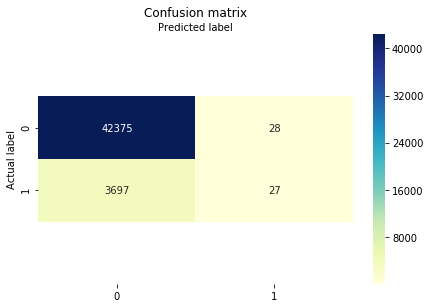

In [39]:
heat_conf(conf_matrix)

Let's see the Accuracy, Precision and Recall values:

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label = 1))

Accuracy: 0.9192446939970083
Precision: 0.4909090909090909
Recall: 0.007250268528464017


Now we can plot the ROC, and calculate the AUC relative to logistic regression.

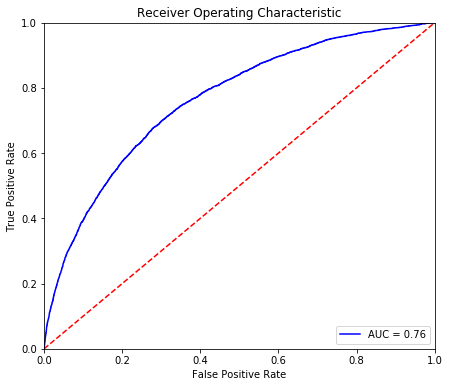

In [41]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = logistic.predict_proba(X_test_best)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [42]:
aucs['Logistic Regression'] = auc

In [43]:
auc

0.7631563305425489

### Random Forest

In [44]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1, max_depth = 10)

# Train the classifier
clf.fit(X_train_sel, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [46]:
# Print the name and gini importance of each feature
for feature in zip(features_sel, clf.feature_importances_):
    print(feature)

('CREDIT_DIV_ANNUITY', 0.01159678956013281)
('EXT_SOURCE_1', 0.02974172583900734)
('EXT_SOURCE_2', 0.09835966170632286)
('EXT_SOURCE_3', 0.08411000081527162)
('DAYS_BIRTH', 0.01633814707108545)
('CREDIT_MINUS_GOOD', 0.02018364590959535)
('DAYS_EMPLOYED', 0.024373220441428103)
('AMT_ANNUITY', 0.005446851259038108)
('ins_PAYMENT_DIFF', 0.009693824019722928)
('POS_CNT_INSTALMENT_FUTURE', 0.0071484773182009876)
('ANNUITY_INCOME_PERCENT', 0.0081921954253868)
('DAYS_ID_PUBLISH', 0.008013110438693644)
('BUR_AMT_CREDIT_SUM_DEBT', 0.0016165165434385684)
('app_CNT_PAYMENT', 0.006176734610371696)
('app_AMT_ANNUITY', 0.005943885761654782)
('POS_prev_pos_count', 0.00645861043142907)
('AMT_CREDIT', 0.0023854767503309524)
('AMT_GOODS_PRICE', 0.002317511129548847)
('ins_DBD', 0.006717353980560119)
('DAYS_LAST_PHONE_CHANGE', 0.008109198923297945)
('DAYS_REGISTRATION', 0.006687673599570697)
('app_AMT_DOWN_PAYMENT', 0.004428239222739186)
('BUR_AMT_CREDIT_MAX_OVERDUE', 0.0011629698066792436)
('BIRTH_DIV_E

In [49]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 
sfm = SelectFromModel(clf, threshold=0.005)

# Train the selector
sfm.fit(X_train_sel, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=10,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=200, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
                                                 warm_star

In [51]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(features_sel[feature_list_index])

CREDIT_DIV_ANNUITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
DAYS_BIRTH
CREDIT_MINUS_GOOD
DAYS_EMPLOYED
AMT_ANNUITY
ins_PAYMENT_DIFF
POS_CNT_INSTALMENT_FUTURE
ANNUITY_INCOME_PERCENT
DAYS_ID_PUBLISH
app_CNT_PAYMENT
app_AMT_ANNUITY
POS_prev_pos_count
ins_DBD
DAYS_LAST_PHONE_CHANGE
DAYS_REGISTRATION
BIRTH_DIV_EMPLOYED
ins_CNT_DRAWINGS_ATM_CURRENT
REGION_POPULATION_RELATIVE
ins_AMT_PAYMENT
BUR_DAYS_CREDIT_ENDDATE
BUR_Loan_FRQ
BUR_DAYS_CREDIT
app_NAME_CONTRACT_STATUS_Refused
ins_NUM_INSTALMENT_NUMBER
ins_ins_count
ins_PAYMENT_PERC
app_HOUR_APPR_PROCESS_START
POS_SK_DPD_DEF
app_NAME_YIELD_GROUP_high
POS_MONTHS_BALANCE
DAYREG_DIV_DAYPUB
BUR_CREDIT_ACTIVE_Closed
BUR_PLoan_num
app_DAYS_DECISION
BUR_DAYS_ENDDATE_FACT
ins_DAYS_ENTRY_PAYMENT
ins_CNT_DRAWINGS_CURRENT
NAME_EDUCATION_TYPE_Higher education
INTEREST_RATE
INTEREST_SHARE
ins_AMT_INSTALMENT
ins_DAYS_INSTALMENT
BUR_CREDIT_TYPE_Microloan
BUR_DAYS_CREDIT_UPDATE
POS_CNT_INSTALMENT
POS_SK_DPD
BUR_CREDIT_ACTIVE_Active
ins_AMT_DRAWINGS_ATM_CURRENT


In [52]:
# Transform the data to create a new dataset containing only the most important features
X_important_train = sfm.transform(X_train_sel)
X_important_test = sfm.transform(X_test_sel)

In [53]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [55]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test_sel)

# View The Accuracy, Precision and Recall Of our model with all features
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label = 1))

Accuracy: 0.9192663732737876
Precision: 0.0
Recall: 0.0


C:\Users\Notebook HP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 576x576 with 0 Axes>

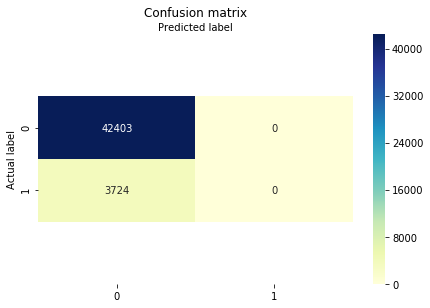

In [59]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
heat_conf(conf_matrix)

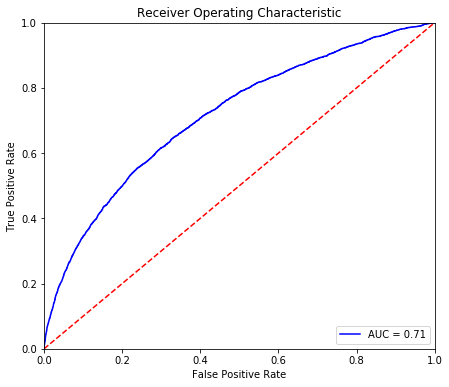

In [65]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = clf.predict_proba(X_test_sel)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [68]:
aucs['Random Forest'] = auc
auc

0.7144069551753591

In [56]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy,Precision and Recall off our model with selected features
print("Accuracy:",metrics.accuracy_score(y_test, y_important_pred))
print("Precision:",metrics.precision_score(y_test, y_important_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_important_pred, pos_label = 1))

Accuracy: 0.9099009257051185
Precision: 0.27263157894736845
Recall: 0.06954887218045112


<Figure size 576x576 with 0 Axes>

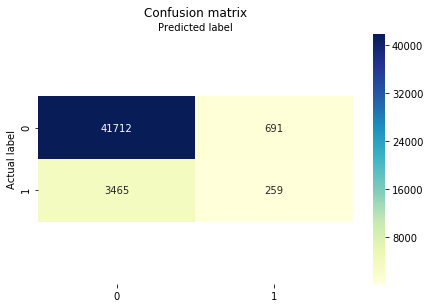

In [58]:
conf_matrix = metrics.confusion_matrix(y_test, y_important_pred)
heat_conf(conf_matrix)

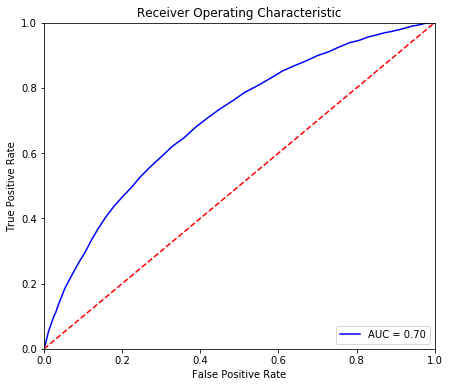

In [69]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = clf_important.predict_proba(X_important_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [70]:
aucs['Random Forest selected'] = auc
auc

0.7008113520127939

### Light gbm

In [72]:
# Defining again the dataframes, without scaling
X_train_sel = X_train[features_sel]
X_val_sel = X_val[features_sel]
X_test_sel = X_test[features_sel]

Since the dataset is unbalanced, with over 90% of target values equal to 0, we need to add weight to give more importance to the target value 1 when is found. (We tried downsampling, but it didn't give better results).

In [73]:
tar_weight = np.ones((len(X_train_sel),), dtype=int)
for i in range(len(X_train_sel)):
    if y_train[i]== 0:
        tar_weight[i]=1
    else:
        tar_weight[i]=10

In [102]:
# lgbm format
train = lgb.Dataset(X_train_sel, label = y_train, weight= tar_weight )
valid = lgb.Dataset(X_val_sel, label = y_val)

Cross Validation to find the best max depth:

In [106]:
cross = []
max_D = [2,3,5,10] # Possible values of max_depth parameter

for i in max_D:
    params = {'boosting_type': 'gbdt',
          'max_depth' : i,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
    lgbm = lgb.train(params,
                 train,
                 2500,
                 valid_sets=valid,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
    y_prob = lgbm.predict(X_val_sel)
    cross.append(roc_auc_score(y_val,y_prob))
best = max_D[np.argmax(cross)]
print('The best max depth is ', best )

Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.702735
[20]	valid_0's auc: 0.710412
[30]	valid_0's auc: 0.71951
[40]	valid_0's auc: 0.727887
[50]	valid_0's auc: 0.733787
[60]	valid_0's auc: 0.738278
[70]	valid_0's auc: 0.741711
[80]	valid_0's auc: 0.74422
[90]	valid_0's auc: 0.7471
[100]	valid_0's auc: 0.74932
[110]	valid_0's auc: 0.751555
[120]	valid_0's auc: 0.753255
[130]	valid_0's auc: 0.755201
[140]	valid_0's auc: 0.756798
[150]	valid_0's auc: 0.758295
[160]	valid_0's auc: 0.759791
[170]	valid_0's auc: 0.760693
[180]	valid_0's auc: 0.761579
[190]	valid_0's auc: 0.762433
[200]	valid_0's auc: 0.763228
[210]	valid_0's auc: 0.764104
[220]	valid_0's auc: 0.764776
[230]	valid_0's auc: 0.765399
[240]	valid_0's auc: 0.766078
[250]	valid_0's auc: 0.766616
[260]	valid_0's auc: 0.76721
[270]	valid_0's auc: 0.767679
[280]	valid_0's auc: 0.768289
[290]	valid_0's auc: 0.768657
[300]	valid_0's auc: 0.769134
[310]	valid_0's auc: 0.769601
[320]	valid_0's auc: 0.

In [107]:
params = {'boosting_type': 'gbdt',
          'max_depth' : 5,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train,
                 2500,
                 valid_sets=valid,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.731249
[20]	valid_0's auc: 0.738782
[30]	valid_0's auc: 0.744702
[40]	valid_0's auc: 0.751484
[50]	valid_0's auc: 0.7561
[60]	valid_0's auc: 0.760151
[70]	valid_0's auc: 0.763206
[80]	valid_0's auc: 0.765448
[90]	valid_0's auc: 0.767182
[100]	valid_0's auc: 0.768764
[110]	valid_0's auc: 0.770068
[120]	valid_0's auc: 0.771389
[130]	valid_0's auc: 0.772248
[140]	valid_0's auc: 0.773328
[150]	valid_0's auc: 0.774247
[160]	valid_0's auc: 0.774851
[170]	valid_0's auc: 0.775483
[180]	valid_0's auc: 0.776014
[190]	valid_0's auc: 0.776567
[200]	valid_0's auc: 0.776978
[210]	valid_0's auc: 0.77746
[220]	valid_0's auc: 0.778103
[230]	valid_0's auc: 0.778562
[240]	valid_0's auc: 0.779051
[250]	valid_0's auc: 0.779454
[260]	valid_0's auc: 0.779785
[270]	valid_0's auc: 0.780073
[280]	valid_0's auc: 0.780317
[290]	valid_0's auc: 0.780565
[300]	valid_0's auc: 0.781104
[310]	valid_0's auc: 0.781273
[320]	valid_0's auc:

In [108]:
y_pred_prob = lgbm.predict(X_test_sel)

In [109]:
y_pred_prob # Probabilities relative to clients

array([0.29220388, 0.13558304, 0.19770325, ..., 0.82145618, 0.21915942,
       0.32094528])

In [110]:
# Giving each predicted probability a target value
y_pred = np.ones((len(X_test_sel),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

In [111]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

<Figure size 576x576 with 0 Axes>

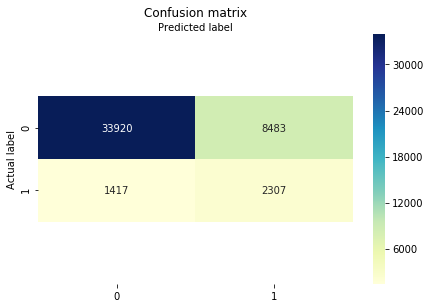

In [112]:
heat_conf(conf_matrix)

In [113]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label = 1))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label = 1))

Accuracy: 0.7853751598846662
Precision: 0.21380908248378128
Recall: 0.6194951664876477


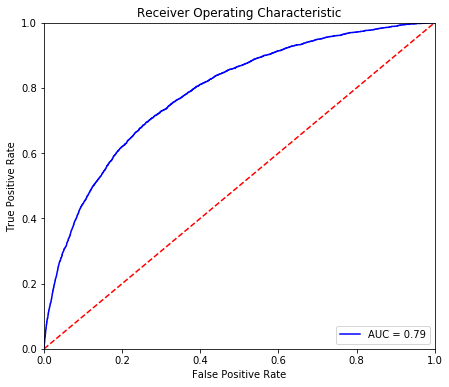

In [114]:
fig = plt.figure(figsize=(7,6))
y_pred_proba = lgbm.predict(X_test_sel)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label = 1)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

In [115]:
aucs['Light GBM'] = auc
auc

0.7865643398202097

In [99]:
best_method = max(aucs.items(), key=operator.itemgetter(1))[0]
best_method

'Light GBM'